In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, roc_auc_score, f1_score,
    matthews_corrcoef, cohen_kappa_score, confusion_matrix
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import featuretools as ft
from sklearn.metrics import accuracy_score, classification_report

# Функция для применения oversampling
def apply_oversampling(X, y):
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    return X_resampled, y_resampled

# Функция для применения undersampling
def apply_undersampling(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):
    """
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    """

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test


df = pd.read_csv("../data/age.csv", nrows=10000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 10000 non-null  object 
 1   Name               10000 non-null  object 
 2   Short description  9996 non-null   object 
 3   Gender             9927 non-null   object 
 4   Country            9721 non-null   object 
 5   Occupation         9836 non-null   object 
 6   Birth year         10000 non-null  int64  
 7   Death year         9999 non-null   float64
 8   Manner of death    1893 non-null   object 
 9   Age of death       9999 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 781.4+ KB


Вариант: Список людей.
Бизнес-цель: реклама. Необходимо разбить людей на группы, чтобы показывать им определенную рекламу в приложениях

In [4]:
df.fillna({"Gender": "NaN", "Country": "NaN", "Occupation" : "NaN", "Manner of death" : "NaN"}, inplace=True)
df = df.dropna()
df['Country'] = df['Country'].str.split('; ')
df = df.explode('Country')
data = df.copy()

value_counts = data["Country"].value_counts()
rare = value_counts[value_counts < 100].index
data = data[~data["Country"].isin(rare)]

data.drop(data[~data['Gender'].isin(['Male', 'Female'])].index, inplace=True)

data1 = data[["Country", "Age of death", "Gender"]]
data1 = pd.get_dummies(data1, drop_first=True)
#data1 = pd.get_dummies(data, columns=['Gender', 'Country', 'Occupation'], drop_first=True)

[[ -1.11861923  -0.74208424]
 [-19.1195007   -0.58172792]
 [-12.11858619  -0.75979619]
 ...
 [ -2.1214623    0.45075518]
 [ 28.87844461   0.50067068]
 [  5.87851368   0.4636366 ]]


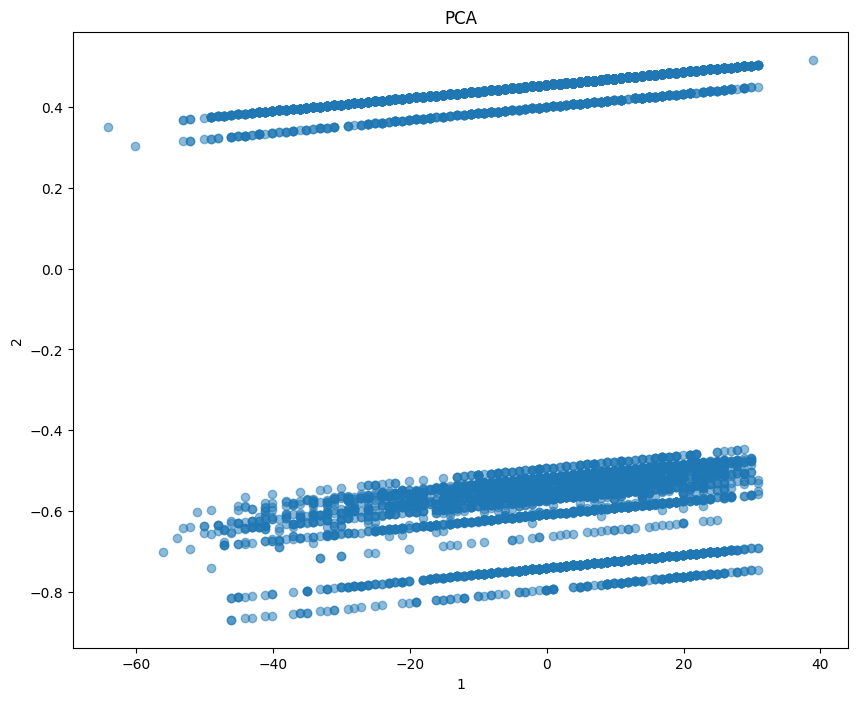

In [10]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data1)

print(data_pca)

plt.figure(figsize=(10, 8))
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5)
plt.title('PCA')
plt.xlabel('1')
plt.ylabel('2')
plt.show()

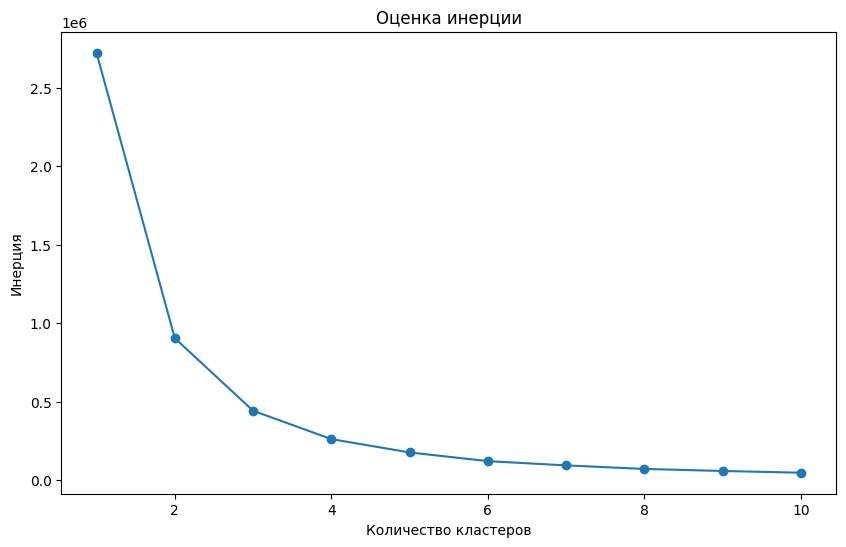

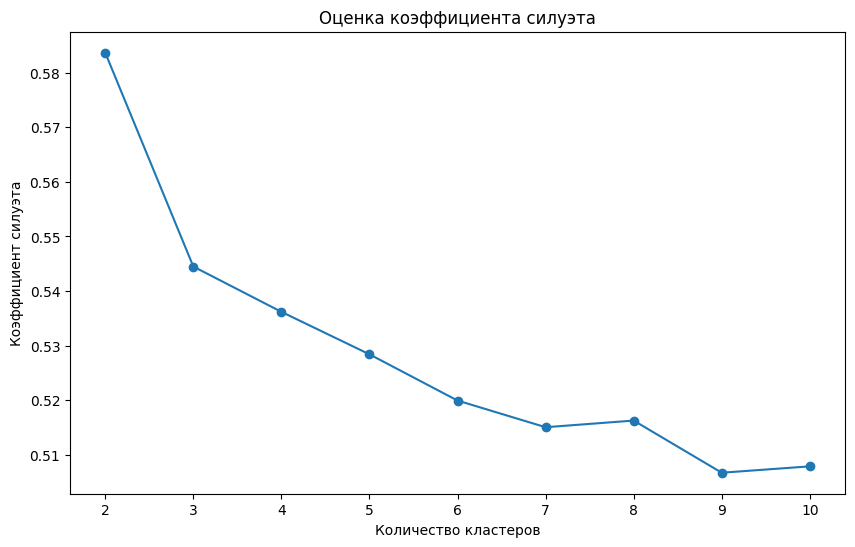

In [12]:
# Оценка инерции
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Оценка инерции')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.show()

# Оценка коэффициента силуэта
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    score = silhouette_score(data_pca, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Оценка коэффициента силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.show()

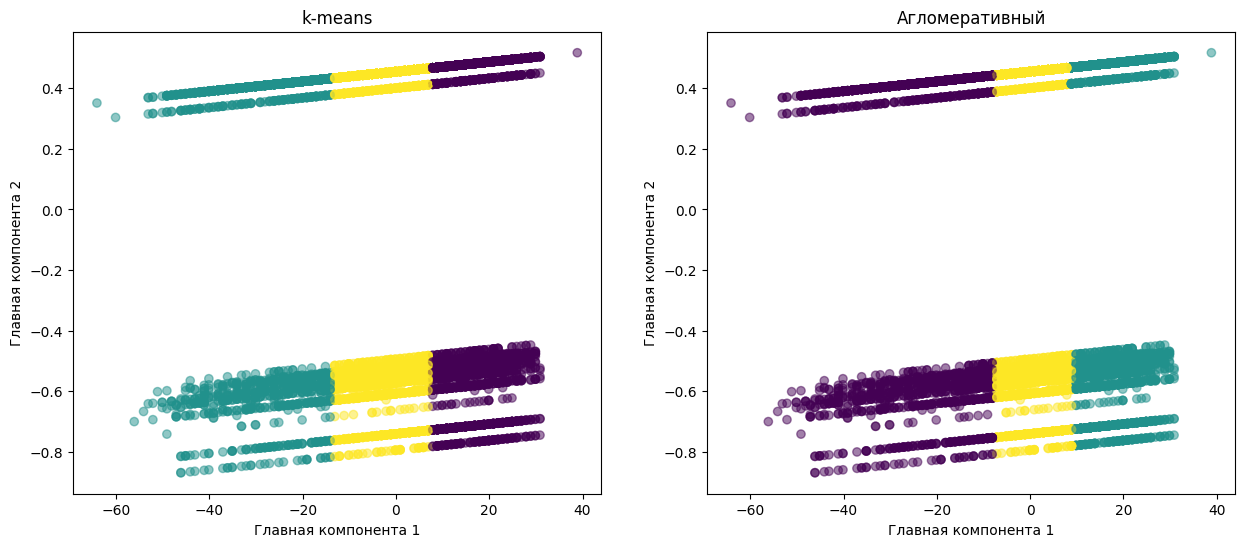

In [20]:
# Неиерархический алгоритм: k-means
optimal_k = 3  # Предположим, что оптимальное количество кластеров равно 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(data_pca)

# Иерархический алгоритм: агломеративный
agglomerative = AgglomerativeClustering(n_clusters=optimal_k)
agglomerative_labels = agglomerative.fit_predict(data_pca)

# Визуализация результатов
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.title('k-means')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')

plt.subplot(1, 2, 2)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=agglomerative_labels, cmap='viridis', alpha=0.5)
plt.title('Агломеративный')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')

plt.show()

In [15]:
# Оценка качества k-means
kmeans_inertia = kmeans.inertia_
kmeans_silhouette = silhouette_score(data_pca, kmeans_labels)

# Оценка качества агломеративной кластеризации
agglomerative_silhouette = silhouette_score(data_pca, agglomerative_labels)

print(f'k-means - Инерция: {kmeans_inertia}, Коэффициент силуэта: {kmeans_silhouette}')
print(f'Агломеративный - Коэффициент силуэта: {agglomerative_silhouette}')

k-means - Инерция: 442804.1358263728, Коэффициент силуэта: 0.5444824210491334
Агломеративный - Коэффициент силуэта: 0.5158480408075595
